In [48]:
!nvidia-smi

Fri Nov  8 19:32:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:B3:00.0 Off |                    0 |
| N/A   29C    P0             52W /  300W |    4340MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Load packages and class

In [1]:
import pandas as pd
import numpy as np
import sys
import yaml

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.clip_grad import clip_grad_norm
from torch.optim import AdamW

from transformers import get_linear_schedule_with_warmup, RobertaModel, RobertaConfig, RobertaTokenizer

from PolymerSmilesTokenization import PolymerSmilesTokenizer
from dataset import Downstream_Dataset, DataAugmentation

from sklearn.metrics import r2_score

from copy import deepcopy

import pickle

/jet/home/entaoy/.conda/envs/TransPoly/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
np.random.seed(seed=1)

In [3]:
class DownstreamRegression(nn.Module):
    def __init__(self, drop_rate=0.1):
        super(DownstreamRegression, self).__init__()
        self.PretrainedModel = deepcopy(PretrainedModel)
        self.PretrainedModel.resize_token_embeddings(len(tokenizer))

        self.Regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(self.PretrainedModel.config.hidden_size, self.PretrainedModel.config.hidden_size),
            nn.SiLU(),
            nn.Linear(self.PretrainedModel.config.hidden_size, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.PretrainedModel(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.last_hidden_state[:, 0, :]
        output = self.Regressor(logits)
        return output

In [4]:
def main(finetune_config):

    """Tokenizer"""
    if finetune_config['add_vocab_flag']:
        vocab_sup = pd.read_csv(finetune_config['vocab_sup_file'], header=None).values.flatten().tolist()
        tokenizer.add_tokens(vocab_sup)

    best_r2 = 0.0           # monitor the best r^2 in the run

    """Data"""
    if finetune_config['CV_flag']:
        #print("Start Cross Validation")
        print('Do not support CV yet!')
        return

    else:
        print("Train Test Split")
        train_data = pd.read_csv(finetune_config['train_file'])
        test_data = pd.read_csv(finetune_config['test_file'])

        if finetune_config['aug_flag']:
            print("Data Augmentation")
            DataAug = DataAugmentation(finetune_config['aug_indicator'])
            train_data = DataAug.smiles_augmentation(train_data)
            if finetune_config['aug_special_flag']:
                train_data = DataAug.smiles_augmentation_2(train_data)
                train_data = DataAug.combine_smiles(train_data)
                test_data = DataAug.combine_smiles(test_data)
            train_data = DataAug.combine_columns(train_data)
            test_data = DataAug.combine_columns(test_data)

        scalers = {}
        for i in range(2):
            scaler = StandardScaler()
            train_data.iloc[:, i+1] = scaler.fit_transform(train_data.iloc[:, i+1].values.reshape(-1, 1))
            test_data.iloc[:, i+1] = scaler.transform(test_data.iloc[:, i+1].values.reshape(-1, 1))
            scalers[i] = scaler

        train_dataset = multitask_Downstream_Dataset(train_data, tokenizer, finetune_config['blocksize'])
        train_dataloader = DataLoader(train_dataset, finetune_config['batch_size'], shuffle=True, num_workers=finetune_config["num_workers"])
        test_dataset = multitask_Downstream_Dataset(test_data, tokenizer, finetune_config['blocksize'])
        test_dataloader = DataLoader(test_dataset, finetune_config['batch_size'], shuffle=False, num_workers=finetune_config["num_workers"])

        """Parameters for scheduler"""
        steps_per_epoch = train_data.shape[0] // finetune_config['batch_size']
        training_steps = steps_per_epoch * finetune_config['num_epochs']
        warmup_steps = int(training_steps * finetune_config['warmup_ratio'])

        """Train the model"""
        model = multi_task_DownstreamRegression(drop_rate=finetune_config['drop_rate']).to(device)
        #model = model.double()
        loss_fn = nn.MSELoss()

        if finetune_config['LLRD_flag']:
            optimizer = roberta_base_AdamW_LLRD(model, finetune_config['lr_rate'], finetune_config['weight_decay'])
        else:
            optimizer = AdamW(
                [
                    {"params": model.PretrainedModel.parameters(), "lr": finetune_config['lr_rate'],
                     "weight_decay": 0.0},
                    {"params": model.Regressor1.parameters(), "lr": finetune_config['lr_rate_reg'],
                     "weight_decay": finetune_config['weight_decay']},
                    {"params": model.Regressor2.parameters(), "lr": finetune_config['lr_rate_reg'],
                     "weight_decay": finetune_config['weight_decay']},
                ]
            )

        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                                    num_training_steps=training_steps)
        torch.cuda.empty_cache()

        train_loss_best, test_loss_best, best_train_r2_avg, best_test_r2_avg = 0.0, 0.0, 0.0, 0.0
        count = 0
 
        for epoch in range(finetune_config['num_epochs']):
            print("epoch: %s/%s" % (epoch+1,finetune_config['num_epochs']))
            multi_task_train(model, optimizer, scheduler, loss_fn, train_dataloader, device)
            train_loss, test_loss, r2_train_task1, r2_train_task2, r2_test_task1, r2_test_task2 = multi_task_test(model, loss_fn, train_dataloader,
                                                                                   test_dataloader, device, scaler, optimizer, scheduler, epoch)
            r2_test_avg = np.mean([r2_test_task1, r2_test_task2])
            if r2_test_avg > best_test_r2_avg:
                best_train_r2_avg = np.mean([r2_train_task1, r2_train_task2])
                best_test_r2_avg = r2_test_avg
                train_loss_best = train_loss
                test_loss_best = test_loss
                count = 0
            else:
                count += 1

            if r2_test_avg > best_r2:
                best_r2 = r2_test_avg
                state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'scheduler': scheduler.state_dict(), 'epoch': epoch}
                torch.save(state, finetune_config['best_model_path'])         # save the best model

            if count >= finetune_config['tolerance']:
                print("Early stop")
                if best_r2 == 0:
                    print("Poor performance with negative r^2")
                break

        if best_r2 != 0:
            print(f'Best train loss: {train_loss_best}')
            print(f'Best test loss: {test_loss_best}')
            print(f'Best mean train R2: {best_train_r2_avg}')
            print(f'Best mean test R2: {best_test_r2_avg}')

        writer.flush()

# Load the pretrained and best model

In [5]:
finetune_config = yaml.load(open("./config_finetune.yaml", "r"), Loader=yaml.FullLoader)

In [6]:
finetune_config

{'CV_flag': False,
 'add_vocab_flag': False,
 'LLRD_flag': False,
 'aug_flag': False,
 'aug_special_flag': False,
 'model_indicator': 'pretrain',
 'aug_indicator': None,
 'vocab_sup_file': None,
 'train_file': 'Egb_train.csv',
 'test_file': 'Egb_test.csv',
 'model_path': '../TransPolymer/ckpt/pretrain.pt',
 'save_path': 'ckpt/Egb_train.pt',
 'best_model_path': 'ckpt/Egb_best_model.pt',
 'num_of_tasks': 1,
 'k': 5,
 'blocksize': 512,
 'batch_size': 32,
 'num_epochs': 20,
 'warmup_ratio': 0.1,
 'drop_rate': 0.1,
 'lr_rate': 0.0001,
 'lr_rate_reg': 5e-05,
 'weight_decay': 1e-05,
 'hidden_dropout_prob': 0.1,
 'attention_probs_dropout_prob': 0.1,
 'tolerance': 5,
 'num_workers': 1}

In [7]:
PretrainedModel = RobertaModel.from_pretrained(finetune_config['model_path'])
PretrainedModel.config.hidden_dropout_prob = finetune_config['hidden_dropout_prob']
PretrainedModel.config.attention_probs_dropout_prob = finetune_config['attention_probs_dropout_prob']

tokenizer = PolymerSmilesTokenizer.from_pretrained("roberta-base", max_len=finetune_config['blocksize'])

Some weights of the model checkpoint at ../TransPolymer/ckpt/pretrain.pt were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ../TransPolymer/ckpt/pretrain.pt and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inf

In [8]:
if finetune_config['add_vocab_flag']:
    vocab_sup = pd.read_csv(finetune_config['vocab_sup_file'], header=None).values.flatten().tolist()
    tokenizer.add_tokens(vocab_sup)

In [9]:
finetune_config['num_workers'] = 1
max_token_len = finetune_config['blocksize']

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
checkpoint = torch.load(finetune_config['best_model_path'])
checkpoint

{'model': OrderedDict([('PretrainedModel.embeddings.position_ids',
               tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
                         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
                         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
                         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
                         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
                         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
                         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
                         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
                        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
                        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138

In [12]:
BestModel = DownstreamRegression(drop_rate=finetune_config['drop_rate']).to(device)
BestModel.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [13]:
checkpoint['epoch']

16

# Retest the best model

In [14]:
train_data = pd.read_csv(finetune_config['train_file'])
test_data = pd.read_csv(finetune_config['test_file'])
train_data.shape, test_data.shape

((448, 2), (113, 2))

In [15]:
scalers = {}
for i in range(1):
    scaler = StandardScaler()
    train_data.iloc[:, i+1] = scaler.fit_transform(train_data.iloc[:, i+1].values.reshape(-1, 1))
    test_data.iloc[:, i+1] = scaler.transform(test_data.iloc[:, i+1].values.reshape(-1, 1))
    scalers[i] = scaler

In [16]:
with open ('Egb_scalers.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [17]:
train_dataset = Downstream_Dataset(train_data, tokenizer, finetune_config['blocksize'])
train_dataloader = DataLoader(train_dataset, finetune_config['batch_size'], shuffle=True, num_workers=finetune_config["num_workers"])
test_dataset = Downstream_Dataset(test_data, tokenizer, finetune_config['blocksize'])
test_dataloader = DataLoader(test_dataset, finetune_config['batch_size'], shuffle=False, num_workers=finetune_config["num_workers"])

In [18]:
def net_predict(model, loss_fn, train_dataloader, test_dataloader, device, scaler):
    train_loss = 0
    test_loss = 0

    model.eval()
    with torch.no_grad():
        #train_pred, train_true, test_pred, test_true = torch.tensor([]), torch.tensor([]), torch.tensor(
        #    []), torch.tensor([])

        all_train_preds = []
        all_train_targets = []
        all_test_preds = []
        all_test_targets = []


        for step, batch in enumerate(train_dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            prop = batch["prop"].to(device).float()
            
            outputs = model(input_ids, attention_mask).float()
            outputs = torch.from_numpy(scaler.inverse_transform(outputs.cpu().reshape(-1, 1)))
            prop = torch.from_numpy(scaler.inverse_transform(prop.cpu().reshape(-1, 1)))
            loss = loss_fn(outputs.squeeze(), prop.squeeze())
            train_loss += loss.item() * len(prop)
            
            all_train_preds.extend(outputs.cpu().numpy())
            all_train_targets.extend(prop.cpu().numpy())

        all_train_preds = np.array(all_train_preds).reshape(-1)
        all_train_targets = np.array(all_train_targets).reshape(-1)

        train_loss = train_loss / len(all_train_preds)
        r2_train = r2_score(all_train_targets, all_train_preds)
        print("train RMSE = ", np.sqrt(train_loss))
        print("task train r^2 = ", r2_train)
        
        for step, batch in enumerate(test_dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            prop = batch["prop"].to(device).float()

            outputs = model(input_ids, attention_mask).float()
            outputs = torch.from_numpy(scaler.inverse_transform(outputs.cpu().reshape(-1, 1)))
            prop = torch.from_numpy(scaler.inverse_transform(prop.cpu().reshape(-1, 1)))
            loss = loss_fn(outputs.squeeze(), prop.squeeze())
            test_loss += loss.item() * len(prop)
            
            all_test_preds.extend(outputs.cpu().numpy())
            all_test_targets.extend(prop.cpu().numpy())
        
        all_test_preds = np.array(all_test_preds).reshape(-1)
        all_test_targets = np.array(all_test_targets).reshape(-1)

        test_loss = test_loss / len(all_test_preds)
        r2_test = r2_score(all_test_targets, all_test_preds)
        print("test RMSE = ", np.sqrt(test_loss))
        print("task test r^2 = ", r2_test)

        return all_train_preds, all_train_targets, all_test_preds, all_test_targets

In [19]:
loss_fn = nn.MSELoss()

In [20]:
all_train_preds, all_train_targets, all_test_preds, all_test_targets = net_predict(BestModel, loss_fn, train_dataloader, test_dataloader, device, scaler)

train RMSE =  0.17900706338881783
task train r^2 =  0.9912955674471413
test RMSE =  0.5538528678917956
task test r^2 =  0.9287039383710415


In [21]:
import matplotlib.pyplot as plt

In [22]:
r2_test = round(r2_score(all_test_targets, all_test_preds), 2)
r2_train = round(r2_score(all_train_targets, all_train_preds), 2)
r2_train, r2_test

(0.99, 0.93)

Text(0, 0.5, 'Predict Egb')

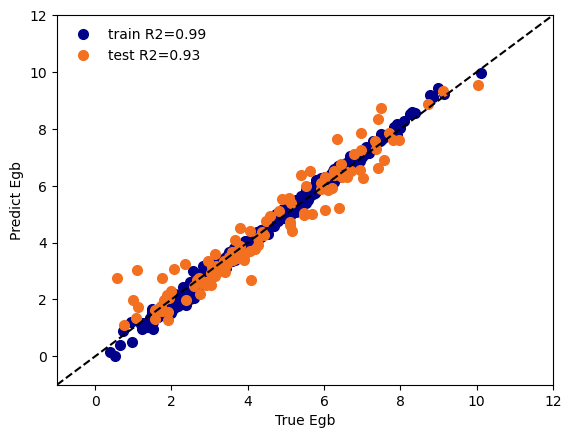

In [23]:
plt.plot(all_train_targets, all_train_preds, 'o', ms=7,  c='darkblue', label=f'train R2={r2_train}')
plt.plot(all_test_targets, all_test_preds, 'o', ms=7, c='#F37021', label=f'test R2={r2_test}')
plt.plot([-1, 18], [-1, 18], 'k--')
plt.xlim(-1, 12)
plt.ylim(-1, 12)
plt.legend(frameon=False)
plt.xlabel('True Egb')
plt.ylabel('Predict Egb')

# Save the embeddings

In [22]:
for name, layer in BestModel.named_children():
    print(f"Layer Name: {name}")

Layer Name: PretrainedModel
Layer Name: Regressor


In [23]:
for batch in train_dataloader:
    print(batch)
    break

{'input_ids': tensor([[   0, 3226,  347,  ...,    1,    1,    1],
        [   0, 3226,  347,  ...,    1,    1,    1],
        [   0, 3226,  487,  ...,    1,    1,    1],
        ...,
        [   0, 3226,  347,  ...,    1,    1,    1],
        [   0, 3226,  347,  ...,    1,    1,    1],
        [   0, 3226,  347,  ...,    1,    1,    1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'prop': tensor([-0.0651, -0.8839, -0.2180,  1.8830,  1.2453, -0.1540, -0.9403, -1.1247,
        -0.9268,  0.3102,  2.0276,  0.1370, -0.8610,  1.0490,  0.3030,  0.1828,
         0.0133, -1.2237,  0.7668, -0.6575,  0.1813, -0.9611,  1.2463, -0.6992,
        -0.1966, -0.8738, -0.1913, -1.1861,  0.4767, -1.3409, -0.9604, -0.0837],
       dtype=torch.float64)}


In [24]:
inputs_id = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)

In [25]:
BestModel

DownstreamRegression(
  (PretrainedModel): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm)

In [27]:
with torch.no_grad():
    result_buffer = BestModel.PretrainedModel(inputs_id, attention_mask)
    logits = result_buffer.last_hidden_state[:, 0, :]
    print(logits.shape)

torch.Size([32, 768])


In [28]:
with torch.no_grad():
    result_buffer2 =  BestModel.Regressor(logits)
    print(result_buffer2.squeeze())

tensor([-0.1118, -1.0253, -0.2324,  2.0043,  1.3266, -0.1079, -0.9431, -1.2789,
        -1.1487,  0.3484,  2.1207,  0.1738, -0.9861,  1.0556,  0.3442,  0.1973,
         0.0454, -1.2831,  0.8174, -0.6773,  0.1566, -1.0539,  1.2529, -0.7610,
        -0.3198, -1.0237, -0.1702, -1.2646,  0.4081, -1.3572, -1.0033, -0.1114],
       device='cuda:0')


In [29]:
with torch.no_grad():
    result_buffer1 = BestModel(inputs_id, attention_mask)
    print(result_buffer1.squeeze())

tensor([-0.1118, -1.0253, -0.2324,  2.0043,  1.3266, -0.1079, -0.9431, -1.2789,
        -1.1487,  0.3484,  2.1207,  0.1738, -0.9861,  1.0556,  0.3442,  0.1973,
         0.0454, -1.2831,  0.8174, -0.6773,  0.1566, -1.0539,  1.2529, -0.7610,
        -0.3198, -1.0237, -0.1702, -1.2646,  0.4081, -1.3572, -1.0033, -0.1114],
       device='cuda:0')


In [30]:
len(result_buffer), result_buffer[0].shape, result_buffer[1].shape

(2, torch.Size([32, 512, 768]), torch.Size([32, 768]))

## train embeddings

In [31]:
all_train_embeddings = []
all_train_targets = []

In [33]:
with torch.no_grad():
    for batch in train_dataloader:
        inputs_id = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        prop = batch["prop"]
        #targets = (prop1, prop2)
        #props = tuple(t.to(device).float() for t in targets)

        embeddings = BestModel.PretrainedModel(inputs_id, attention_mask).last_hidden_state[:, 0, :]
        all_train_embeddings.extend(embeddings.detach().cpu().numpy())
        all_train_targets.extend(prop.detach().cpu().numpy())

In [34]:
len(all_train_embeddings), len(all_train_targets)

(448, 448)

In [35]:
all_train_embeddings[0].shape, all_train_targets[0]

((768,), 1.10654705240838)

In [36]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, targets):
        self.embeddings = embeddings
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return {
            'embedding': self.embeddings[idx],
            'target': self.targets[idx]
        }

In [37]:
train_embedding_dataset = EmbeddingDataset(all_train_embeddings, all_train_targets)

In [38]:
train_embedding_loader = DataLoader(train_embedding_dataset, batch_size=16, shuffle=True)

In [39]:
for batch in train_embedding_loader:
    print(batch['embedding'])
    print(batch['target'])
    break

tensor([[-0.0285, -1.2384, -0.2883,  ..., -1.0764, -0.8853, -0.7945],
        [ 1.0407, -0.1192,  0.3000,  ...,  0.3064, -0.7882, -0.0353],
        [ 0.7843, -0.6434,  0.1756,  ..., -0.8443,  0.8534,  1.6841],
        ...,
        [-0.1013, -1.0822, -1.2498,  ..., -0.3737, -0.6658, -0.0979],
        [-0.3620,  1.0205,  0.1001,  ..., -1.0709, -0.9430,  0.5038],
        [ 0.4271, -0.2754,  0.5349,  ...,  0.2631, -0.2633,  0.6873]])
tensor([ 1.2877, -0.1153, -0.0226, -0.0687, -1.4504,  1.6737, -1.0568, -1.2665,
         0.4071, -0.7896,  2.5662, -0.0837,  1.0681,  0.9013, -0.9965,  0.2907],
       dtype=torch.float64)


## test embeddings

In [40]:
all_test_embeddings = []
all_test_targets = []

In [41]:
with torch.no_grad():
    for batch in test_dataloader:
        inputs_id = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        prop = batch["prop"]

        embeddings = BestModel.PretrainedModel(inputs_id, attention_mask).last_hidden_state[:, 0, :]
        all_test_embeddings.extend(embeddings.detach().cpu().numpy())
        all_test_targets.extend(prop.detach().cpu().numpy())

In [42]:
len(all_test_embeddings), len(all_test_targets)

(113, 113)

In [43]:
all_test_embeddings[0].shape, all_test_targets[0]

((768,), 1.706807104253038)

In [44]:
test_embedding_dataset = EmbeddingDataset(all_test_embeddings, all_test_targets)
test_embedding_loader = DataLoader(test_embedding_dataset, batch_size=16, shuffle=False)

## save the emdedding dataset

In [24]:
import pickle

In [46]:
with open('test_embedding_dataset.pkl', 'wb') as file:
    pickle.dump(test_embedding_dataset, file)

In [47]:
with open('train_embedding_dataset.pkl', 'wb') as file:
    pickle.dump(train_embedding_dataset, file)

# Load the embeddings

In [25]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, targets):
        self.embeddings = embeddings
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return {
            'embedding': self.embeddings[idx],
            'target': self.targets[idx]
        }

In [26]:
with open('train_embedding_dataset.pkl', 'rb') as file:
    train_embedding_dataset = pickle.load(file)

with open('test_embedding_dataset.pkl', 'rb') as file:
    test_embedding_dataset = pickle.load(file)

In [27]:
train_embedding_loader = DataLoader(train_embedding_dataset, batch_size=32, shuffle=True)
test_embedding_loader = DataLoader(test_embedding_dataset, batch_size=32, shuffle=False)

## extract the data and save as dataframe

In [28]:
data = []
labels = []

for item in train_embedding_dataset:
    embedding, targets = item['embedding'], item['target']
    features_np = embedding
    label_np = targets
    
    data.append(features_np)
    labels.append(label_np)

In [52]:
train_df = pd.DataFrame(data)
train_df['label'] = labels
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,label
0,1.560594,-2.382237,0.956057,-0.198063,-0.501130,0.233989,0.200208,0.792393,0.285010,0.797878,...,-1.003333,0.965132,-0.525559,2.061124,0.138329,1.793979,-0.707207,1.266802,0.455330,1.106547
1,1.003248,-1.346584,0.413374,-0.647036,-0.324648,-0.053772,-0.360967,1.429748,-0.046639,-0.492197,...,0.348669,1.468865,0.570917,1.785302,-0.392274,0.600951,-0.524700,1.419789,0.844540,1.156269
2,1.321669,-0.815324,0.115315,-0.201247,1.111159,-0.384891,-0.081085,1.755892,0.457631,-0.636204,...,0.690081,2.225015,1.621164,1.243560,0.105488,-0.012932,0.336591,0.384113,1.043511,0.167198
3,0.201653,0.736787,0.021862,1.623557,1.114433,-0.052302,-1.697209,-0.233903,1.183754,-1.630202,...,0.195837,-0.547598,0.783031,-0.494103,-0.968239,-0.427447,-2.088142,-0.025430,1.415122,-1.694562
4,-0.284803,1.419083,0.423638,1.125827,0.246556,0.692037,-0.352744,0.203204,1.863184,-0.286428,...,-0.854522,-0.943492,0.108798,-0.532969,-0.069460,-0.235801,-0.408842,-0.534133,0.330496,-0.981151


In [53]:
train_df.shape

(448, 769)

In [54]:
data = []
labels = []

for item in test_embedding_dataset:
    embedding, targets = item['embedding'], item['target']
    features_np = embedding
    label_np = targets
    
    data.append(features_np)
    labels.append(label_np)

In [55]:
test_df = pd.DataFrame(data)
test_df['label'] = labels
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,label
0,-0.337437,-2.367648,0.368473,-0.325501,-2.005427,-1.674404,-0.231191,0.676096,1.089512,1.634481,...,-1.470915,1.056201,1.093445,0.888114,0.760125,1.442041,1.147805,0.338203,0.043912,1.706807
1,0.436719,1.378371,0.307330,0.609480,0.761971,0.726327,0.547962,0.215876,1.441017,0.086165,...,-0.509894,-0.444186,0.503573,-0.955956,0.550100,-0.276242,0.567406,-0.440253,0.822559,-1.246543
2,0.433224,0.776043,0.589574,0.972771,0.794333,1.724096,-0.467033,0.932121,0.745412,-0.162922,...,-0.997482,-0.029011,0.712221,0.622517,0.141544,0.488706,-0.787388,0.302615,1.857502,-0.963013
3,0.752481,-0.304472,-0.487444,0.528325,0.382826,-0.778203,-1.970060,1.110641,2.677138,0.311985,...,-0.416036,0.400293,1.209160,1.353915,0.266387,1.009569,1.090849,0.578262,0.372141,0.470116
4,-0.136437,1.488110,0.077481,0.950936,0.422791,0.031333,0.133292,-0.318642,2.100620,0.159533,...,-0.528266,-0.774067,0.118211,-1.033404,0.445139,-0.456451,-0.125542,-1.185429,-0.010726,-1.199062


In [56]:
test_df.shape

(113, 769)

In [57]:
train_df.to_csv('./train_embedding_df.csv', index=False)
test_df.to_csv('./test_embedding_df.csv', index=False)